## **Libraies and Load Image**

In [1]:
!apt-get install tesseract-ocr -y
!pip install pytesseract opencv-python-headless matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,077 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123635 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [10]:
import pytesseract
from pytesseract import Output
import cv2
import matplotlib.pyplot as plt
import re
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
image_path = '/content/drive/MyDrive/invoice_sample.png'

## **Load and Visualize Invoice Image**

This code loads the invoice image from the specified path using OpenCV and displays it using Matplotlib. The image is converted from BGR (OpenCV default) to RGB format for proper visualization in a Jupyter/Colab notebook.


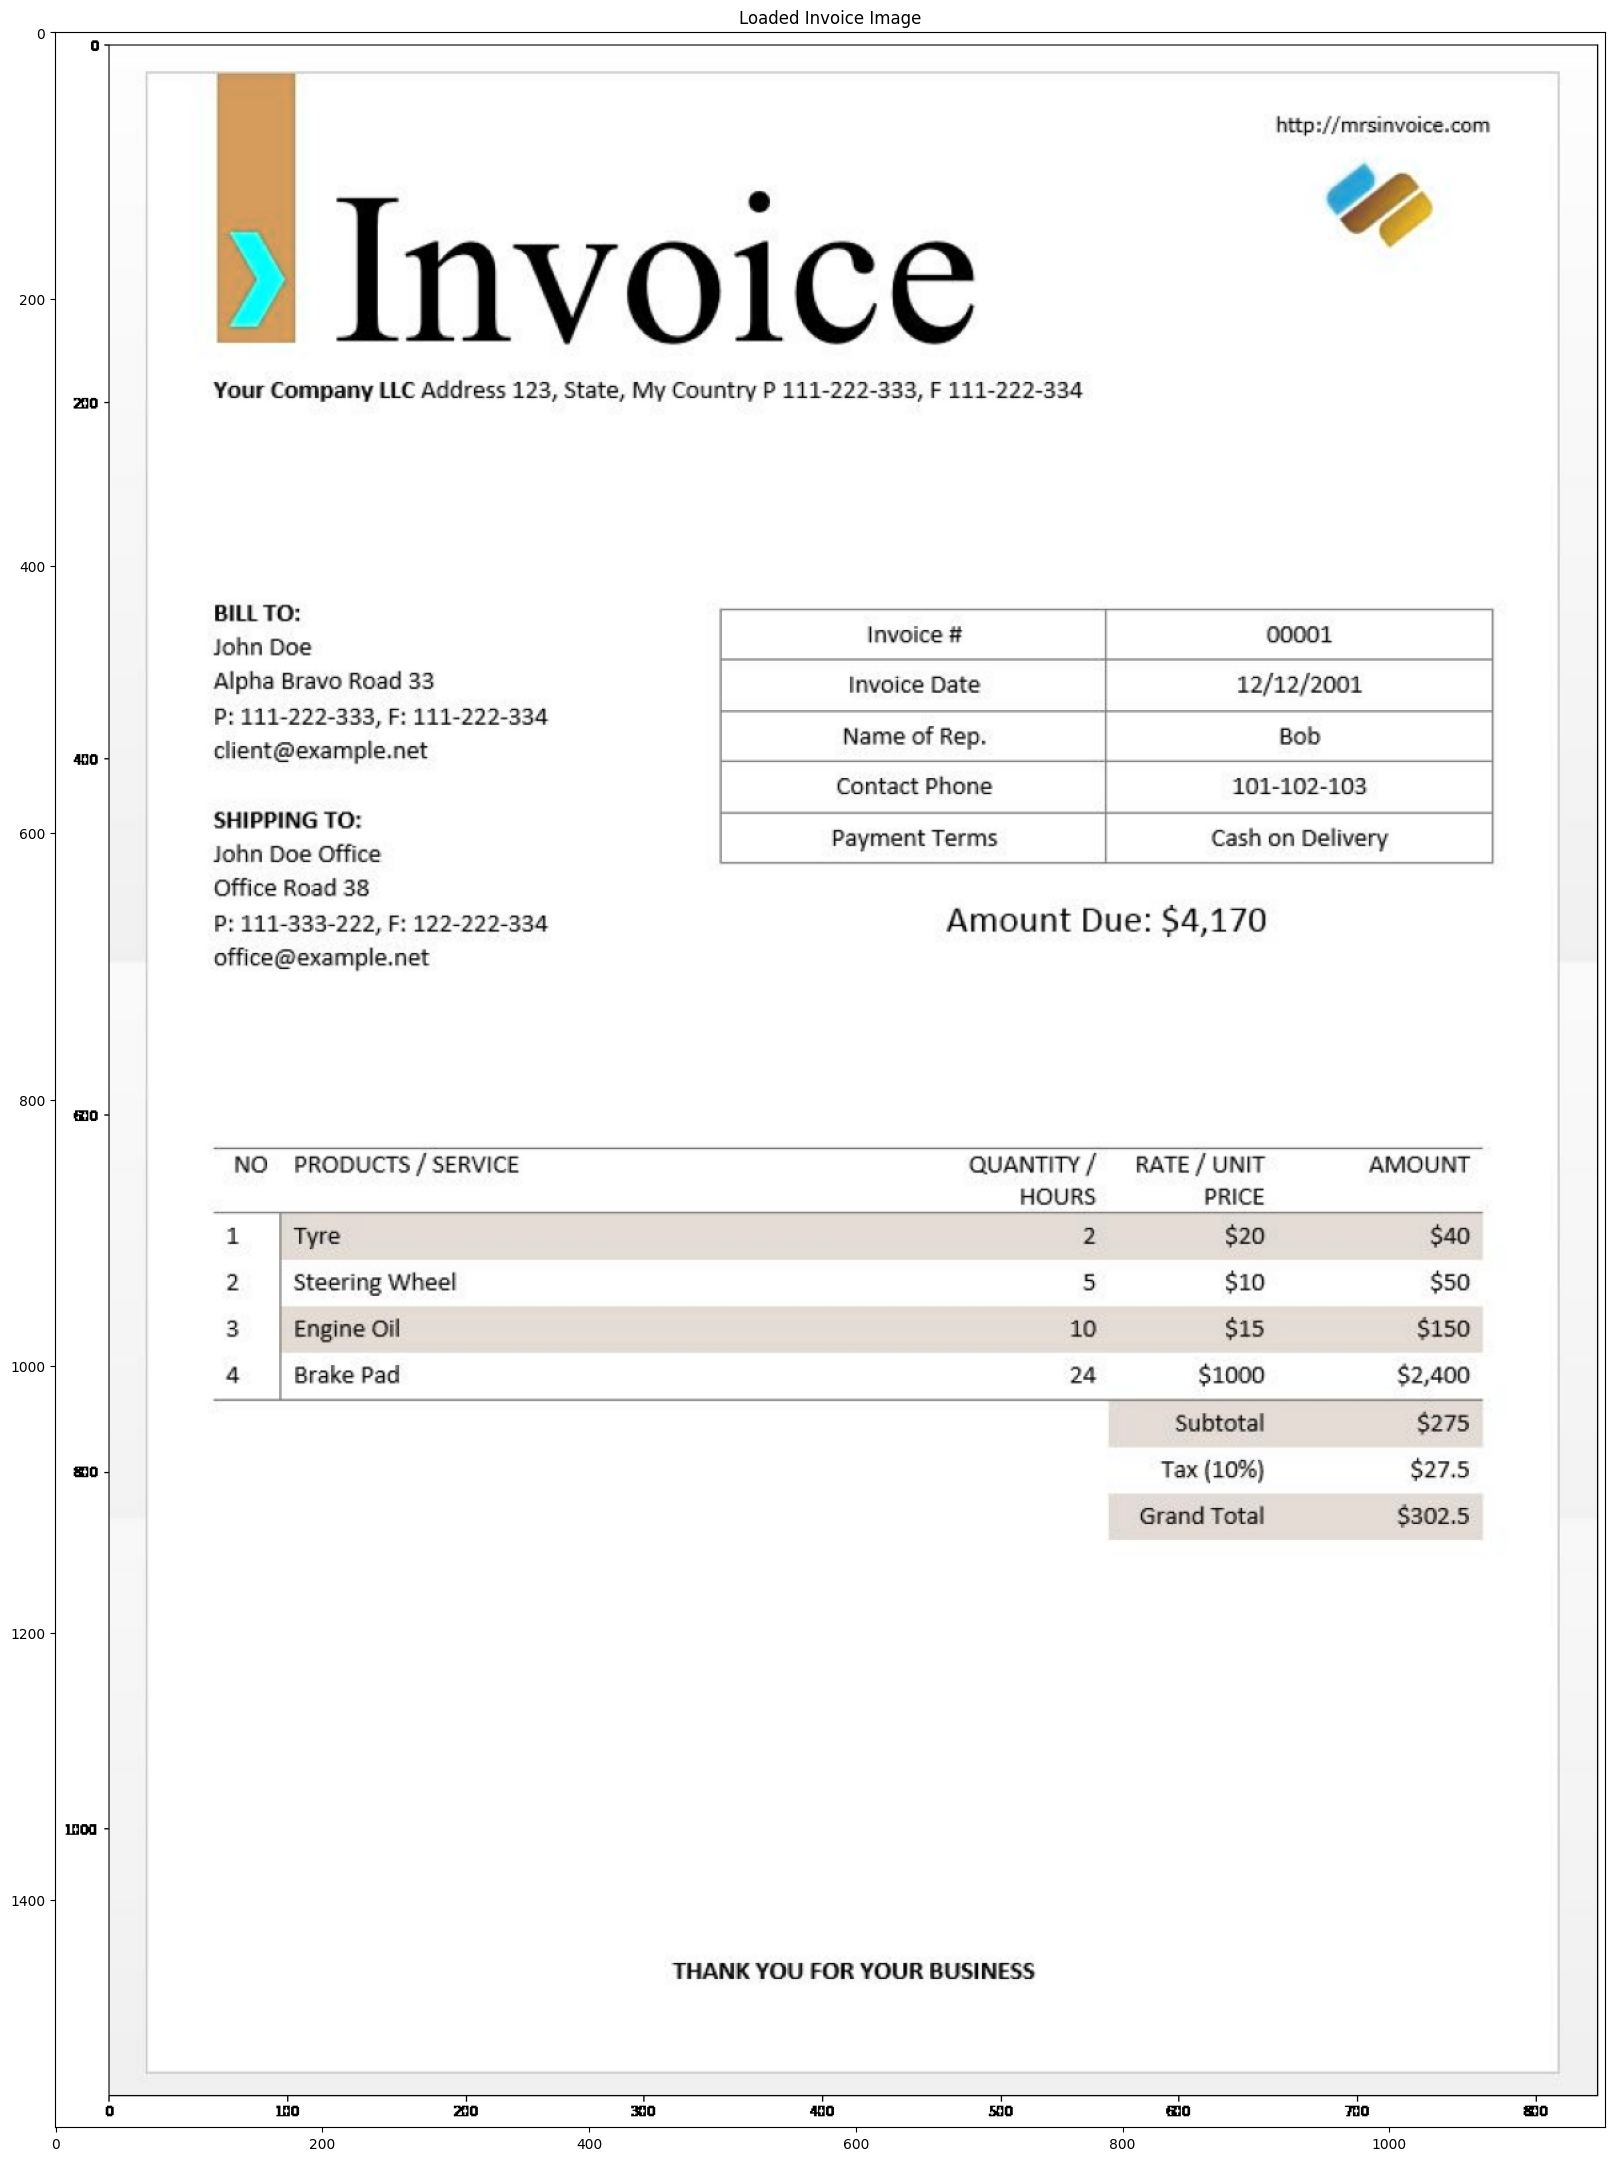

In [5]:
plt.rcParams["figure.figsize"] = (20, 30)

# Set the path to your image
image_path = '/content/drive/MyDrive/invoice_sample.png'

# Load the image
img = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Loaded Invoice Image")
plt.show()

## **Extract Text and Display Bounding Boxes**

This code uses `pytesseract` to extract text and its bounding box coordinates from the loaded image. Text with a confidence score above a specified threshold (60) is highlighted with green rectangles, and the extracted text is displayed above each box. The updated image with bounding boxes is visualized using Matplotlib.


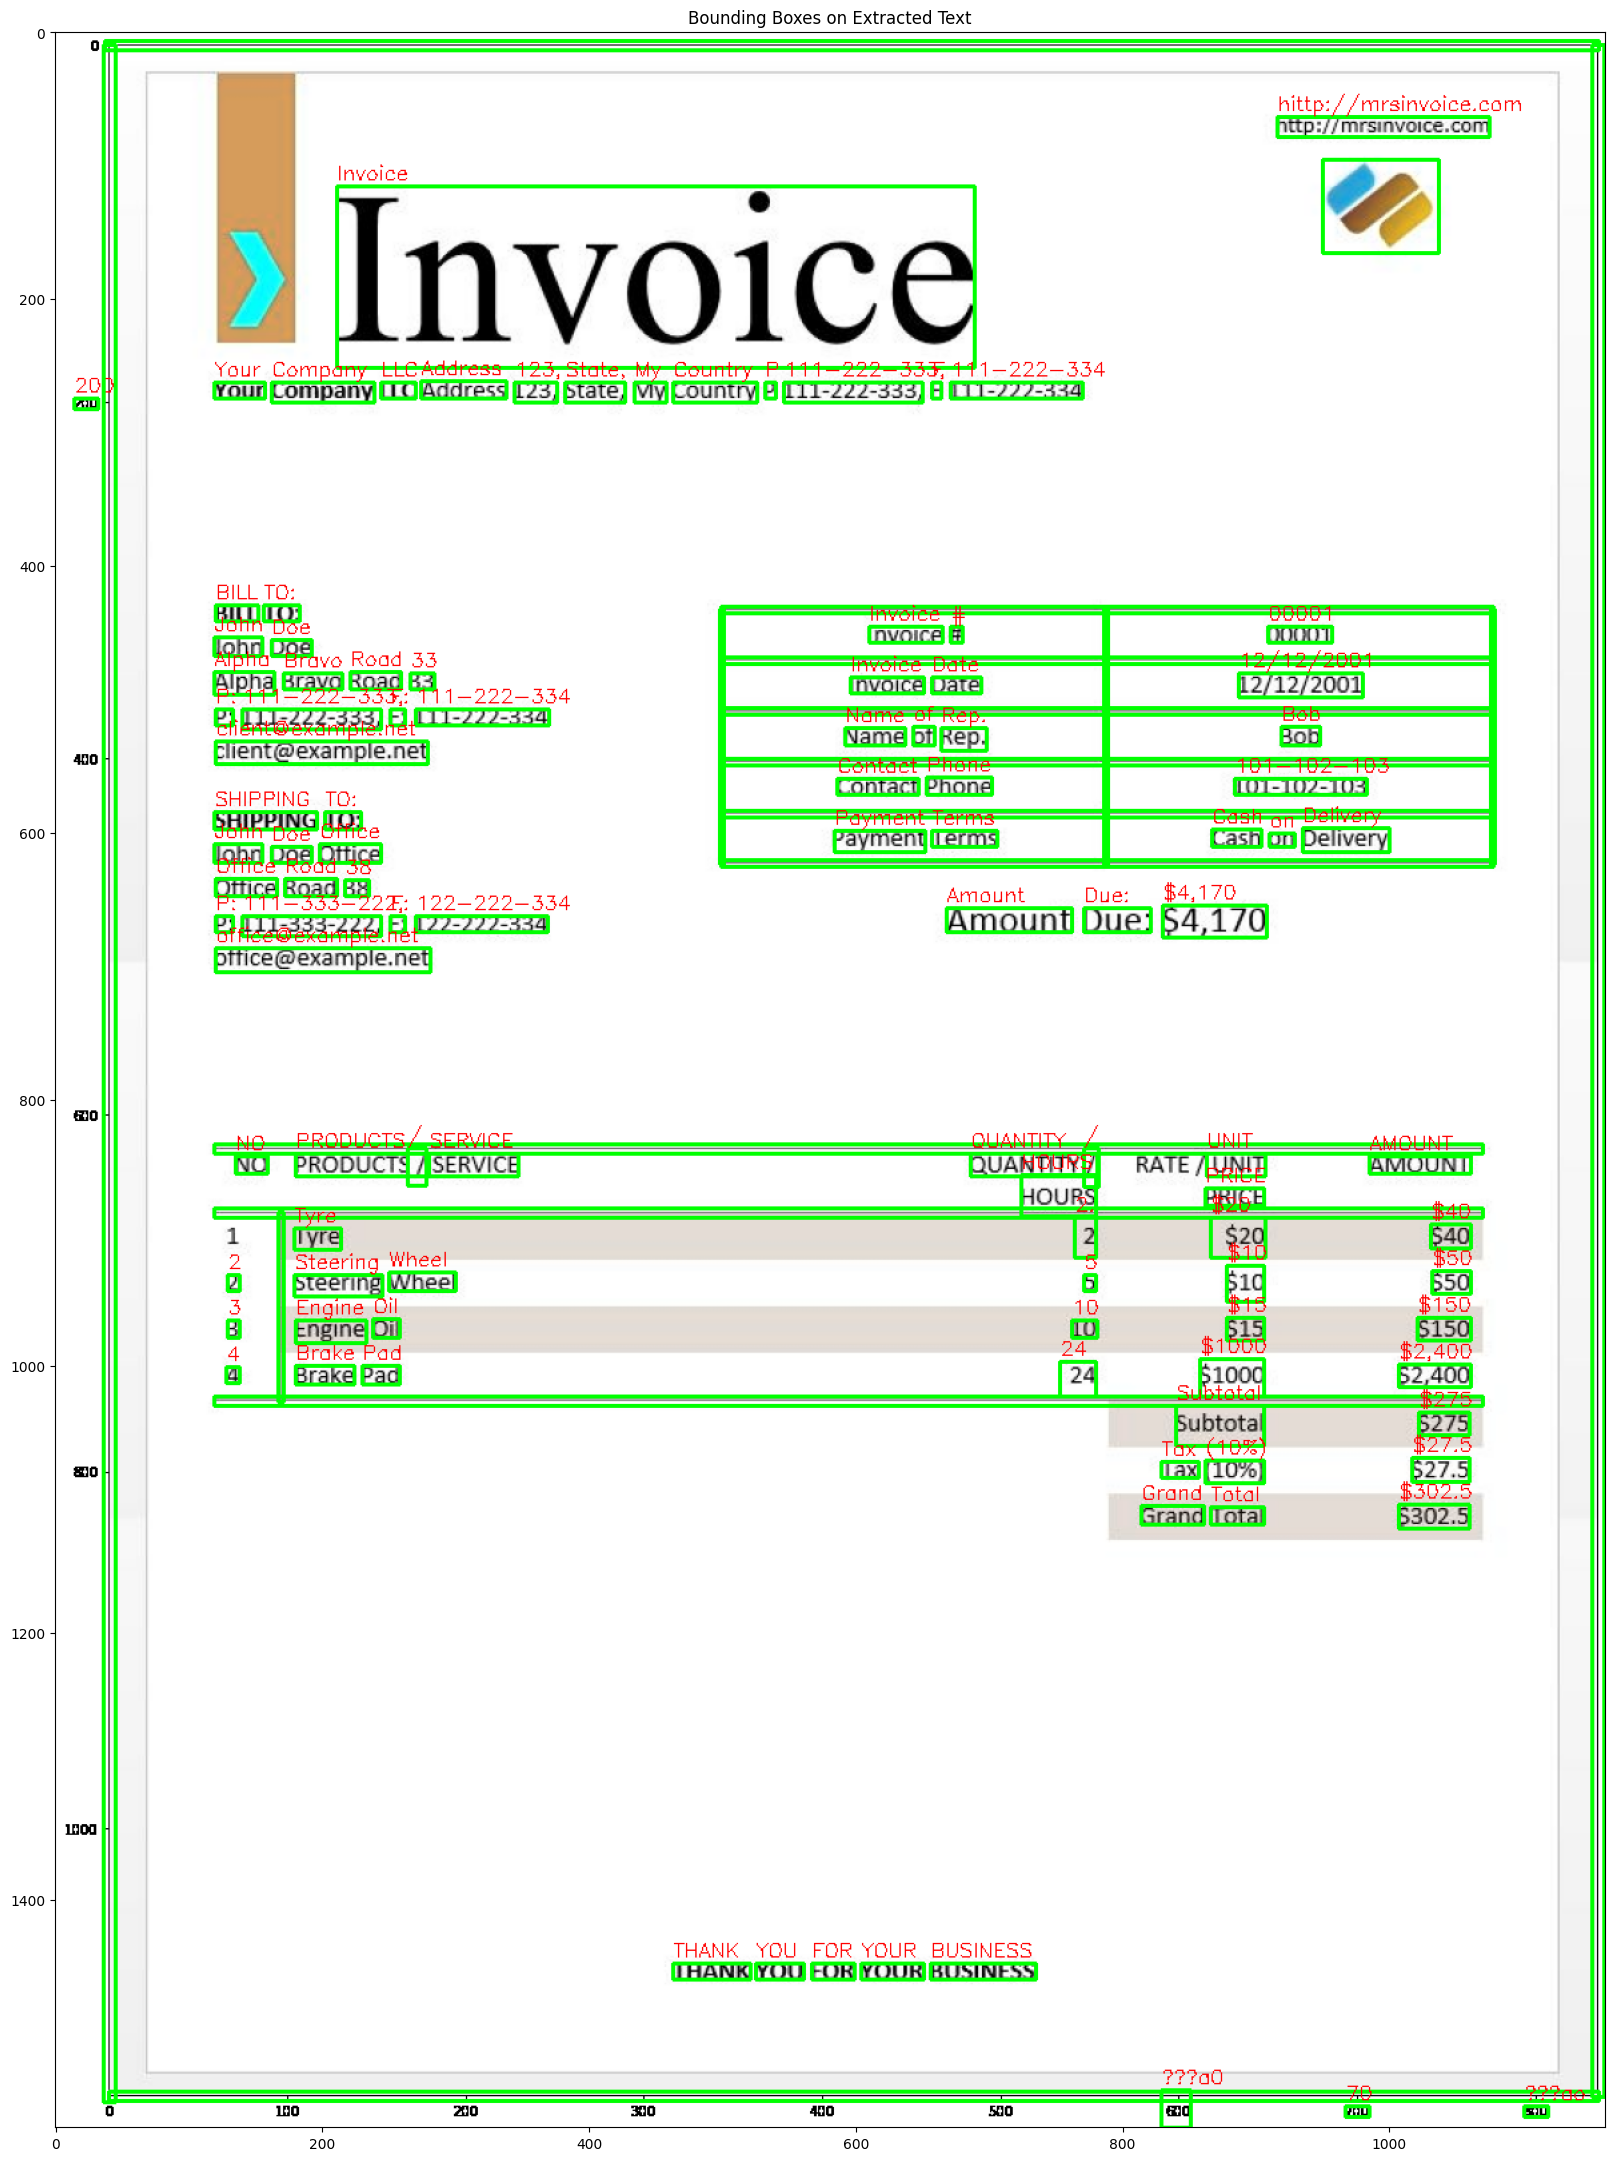

In [6]:
# Extract text and bounding box data
data = pytesseract.image_to_data(img, output_type=Output.DICT)

# Display bounding boxes and extracted text
n_boxes = len(data['text'])
for i in range(n_boxes):
    if int(data['conf'][i]) > 60:  # Confidence threshold
        (x, y, w, h) = data["left"][i], data["top"][i], data["width"][i], data["height"][i]
        img = cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        img = cv2.putText(img, data['text'][i], (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# Show image with bounding boxes
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Bounding Boxes on Extracted Text")
plt.show()

## **Highlight Email Addresses in the Image**

This code reloads the original image and uses `pytesseract` to extract text. It applies a regex pattern to identify email addresses and highlights them with blue bounding boxes if the confidence score exceeds 60. Detected email addresses are printed to the console, and the updated image is displayed using Matplotlib.


Email Found: client@example.net
Email Found: office@example.net


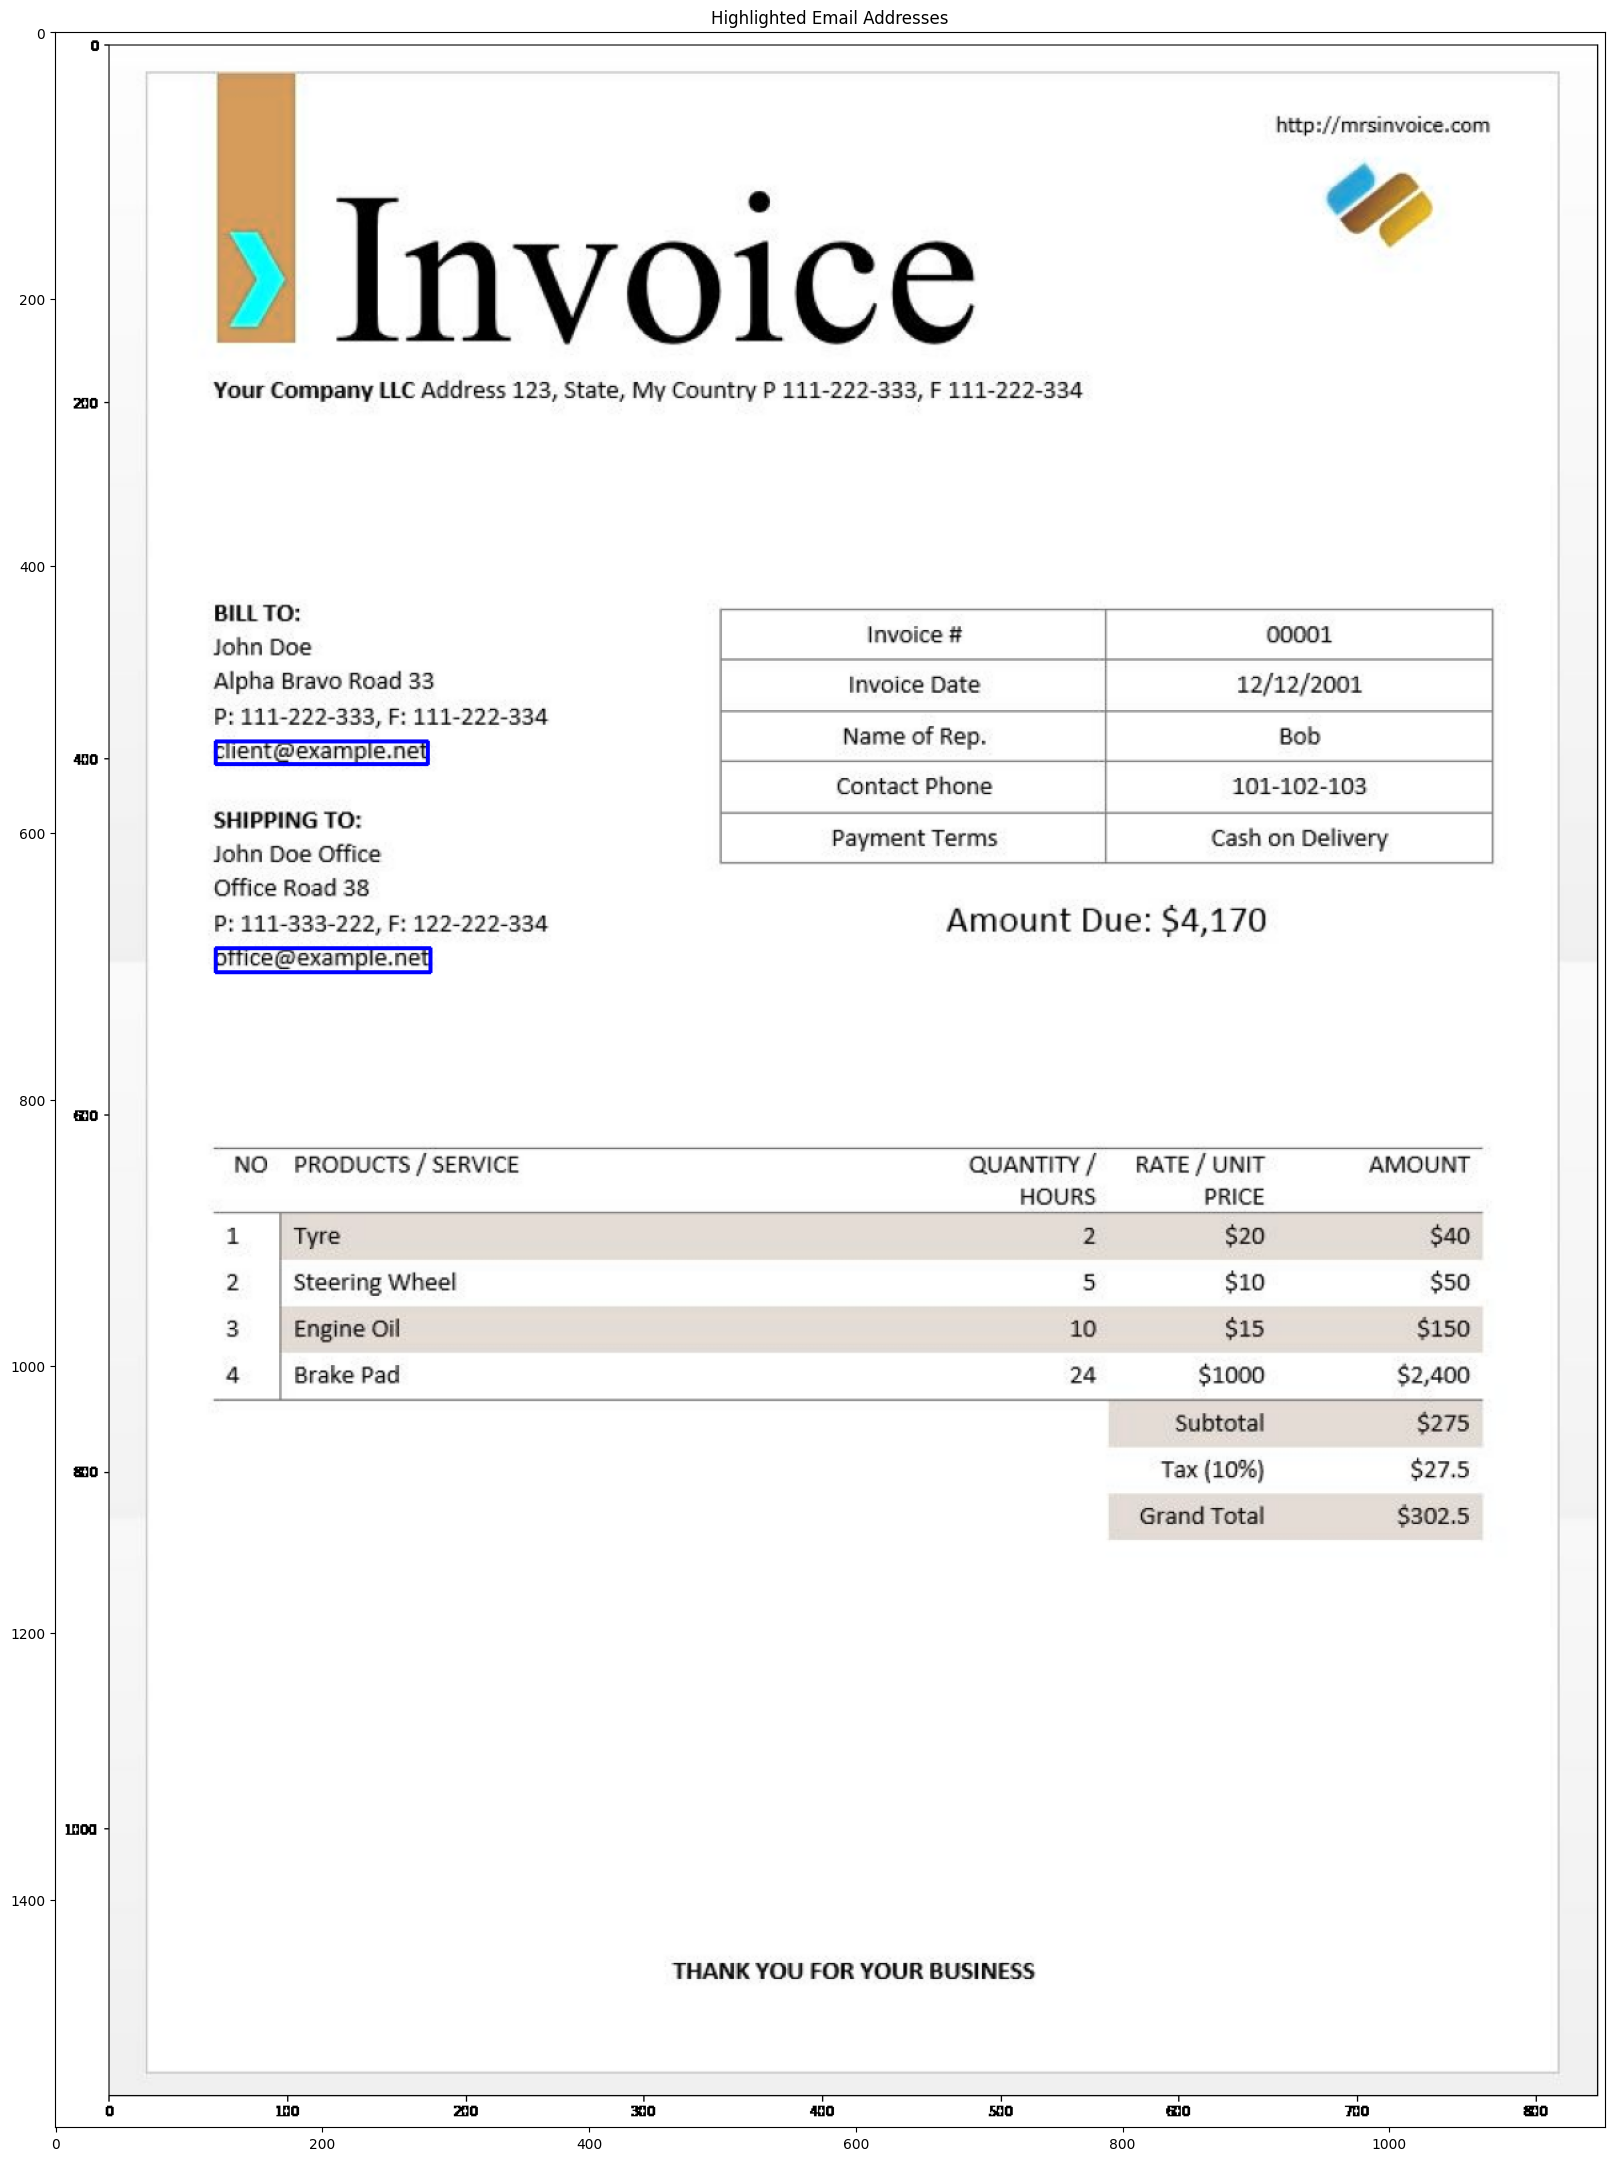

In [7]:
# Reload the original image
img = cv2.imread(image_path)

# Define email regex pattern
email_pattern = r'\S+@\S+'

# Highlight email addresses
for i in range(n_boxes):
    if int(data['conf'][i]) > 60 and re.match(email_pattern, data['text'][i]):
        (x, y, w, h) = data["left"][i], data["top"][i], data["width"][i], data["height"][i]
        img = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)  # Blue box for emails
        print(f"Email Found: {data['text'][i]}")

# Display the image with highlighted email addresses
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Highlighted Email Addresses")
plt.show()

## **Extract Key-Value Pairs Based on Keywords**

This code defines a list of keywords (e.g., "Invoice #", "Invoice Date") and uses OCR data to locate the keyword matches in the image. For each keyword, it finds the corresponding value located to the right of the keyword and extracts it. The results are stored in a dictionary and printed to the console, showing key-value pairs for fields like the invoice number, date, representative name, etc.


In [8]:
# Define keywords to search for
keywords = ["Invoice #", "Invoice Date", "Name of Rep.", "Contact Phone", "Payment Terms"]
results = {}

# Function to find multi-word keyword matches
def find_keyword_match(keyword, ocr_data):
    keyword_parts = keyword.split()
    match_indices = []

    # Search for consecutive words that match the keyword parts
    for i in range(len(ocr_data) - len(keyword_parts) + 1):
        consecutive_match = all(
            ocr_data[i + j]['text'].lower() == keyword_parts[j].lower()
            for j in range(len(keyword_parts))
        )
        if consecutive_match:
            match_indices.append(i)

    return match_indices

# Extract OCR data and clean
ocr_data = [
    {"text": data['text'][i], "left": data['left'][i], "top": data['top'][i]}
    for i in range(len(data['text']))
    if data['text'][i].strip() and int(data['conf'][i]) > 50
]

# Search for each keyword and extract values
for keyword in keywords:
    indices = find_keyword_match(keyword, ocr_data)
    for index in indices:
        # Find position of the last word of the keyword
        keyword_left = ocr_data[index + len(keyword.split()) - 1]['left']
        keyword_top = ocr_data[index]['top']

        # Find text to the right of the keyword
        closest_value = ""
        min_distance = float('inf')
        for candidate in ocr_data:
            if (
                abs(candidate['top'] - keyword_top) < 10  # Same row
                and candidate['left'] > keyword_left  # To the right
            ):
                distance = candidate['left'] - keyword_left
                if distance < min_distance:
                    min_distance = distance
                    closest_value = candidate['text']

        # Refine Invoice # handling for specific cases
        if keyword == "Invoice #":
            # Clean up the invoice number and remove non-alphanumeric characters
            closest_value = re.sub(r"[^\d]", "", closest_value)  # Keep only digits (removes other chars)
            if closest_value.startswith("0"):
                closest_value = closest_value.zfill(5)  # Ensure leading zeros are kept

        results[keyword] = closest_value
        break  # Stop after first match

# Print results
print("\nExtracted Key-Value Pairs:")
for key, value in results.items():
    print(f"{key}: {value}")


Extracted Key-Value Pairs:
Invoice #: 00001
Invoice Date: 12/12/2001
Name of Rep.: Bob
Contact Phone: 101-102-103
Payment Terms: Cash


## **Extract Table Data Using Contours and OCR**

This code preprocesses the image by converting it to grayscale and applying thresholding to enhance text visibility. It then uses contours to detect a table-like region in the image. After identifying the table region, OCR is applied to extract text data. The extracted text is grouped into rows based on vertical alignment, and valid rows are sorted and filtered. Finally, the data is converted into a pandas DataFrame for structured display, showing key columns such as "NO", "PRODUCTS / SERVICE", "QUANTITY / HOURS", "RATE / UNIT PRICE", and "AMOUNT".


In [24]:
# Load and preprocess the image
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 8)

# Detect table-like contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
table_roi = None

# Find the largest table-like region
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > 500 and h > 200:  # Table size threshold
        table_roi = img[y:y+h, x:x+w]
        break

if table_roi is None:
    print("No table detected!")
else:
    # OCR on Table ROI
    data = pytesseract.image_to_data(table_roi, output_type=Output.DICT)

    # Clean and structure OCR data
    ocr_data = [
        {"text": data['text'][i], "left": data['left'][i], "top": data['top'][i], "conf": int(data['conf'][i])}
        for i in range(len(data['text']))
        if data['text'][i].strip() and int(data['conf'][i]) > 50
    ]

    # Group text into rows using 'top' coordinate
    rows = {}
    for item in ocr_data:
        row_key = item['top'] // 10  # Group rows with 10-pixel tolerance
        if row_key not in rows:
            rows[row_key] = []
        rows[row_key].append((item['left'], item['text']))

    # Parse rows dynamically
    table = []
    for _, row in sorted(rows.items(), key=lambda x: x[0]):
        row = sorted(row, key=lambda x: x[0])  # Sort by left position
        parsed_row = []
        product_name = []

        for text in [entry[1] for entry in row]:
            if text.isdigit():  # NO or QUANTITY column
                if product_name:
                    parsed_row.append(" ".join(product_name))
                    product_name = []
                parsed_row.append(text)
            elif re.match(r'^\$?\d+(\.\d+)?$', text):  # RATE or AMOUNT column
                if product_name:
                    parsed_row.append(" ".join(product_name))
                    product_name = []
                parsed_row.append(text)
            else:  # Product Name
                product_name.append(text)

        if product_name:  # Append remaining product name
            parsed_row.append(" ".join(product_name))

        # Ensure row has at least 5 columns
        if len(parsed_row) == 5:
            table.append(parsed_row)

    # Convert to DataFrame
    columns = ["NO", "PRODUCTS / SERVICE", "QUANTITY / HOURS", "RATE / UNIT PRICE", "AMOUNT"]
    df = pd.DataFrame(table, columns=columns)

    # Display results
    print("\nFinal Extracted Table:")
    display(df)


Final Extracted Table:


,NO,PRODUCTS / SERVICE,QUANTITY / HOURS,RATE / UNIT PRICE,AMOUNT
0,3,Engine Oil,10,$15,$150
